In [1]:
import collections
import multiprocessing
import threading
import random
import redis
import requests
import json
import sys
import time

import tornado.httpclient
import tornado.ioloop
import tornado.gen


rps = collections.defaultdict(list)
cpu_stats = []
lock = threading.Lock()
redis_cli = redis.StrictRedis('localhost', 63799)

SAMPLE_TIME = 5. # Seconds
RESOLUTION = 1.
ENDPOINT = 'http://api.io:8080/bounded/network_io'
loop = tornado.ioloop.IOLoop.current()
threads = []


@tornado.gen.coroutine
def main():
    print("Starting main...")
    client = tornado.httpclient.AsyncHTTPClient()
    requests_per_second = RESOLUTION
    while True:
        yield tornado.gen.sleep(1.)
        try:
            redis_cli.incr('client_requests')
            resp = yield client.fetch(ENDPOINT)
            if 200 <= resp.code < 300:
                redis_cli.incr('client_requests_succeeded')
                result = json.loads(resp.body)
                with lock:
                    cpu_stats.append(result)
            else:
                redis_cli.incr('client_requests_failed')
        except Exception, e:
            print("Caught exception", e)
            redis_cli.incr('client_requests_failed')
            

loop.call_later(0., main)


Starting main...


duration


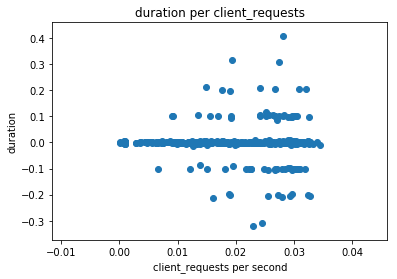

duration
server_requests


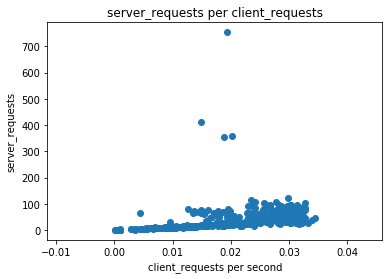

server_requests
host.process.soft_interrupts


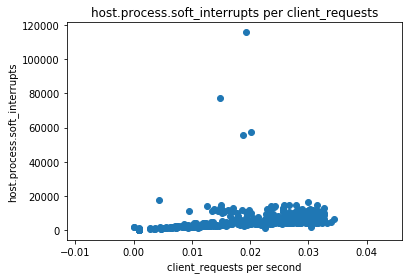

host.process.soft_interrupts
host.process.context_switches


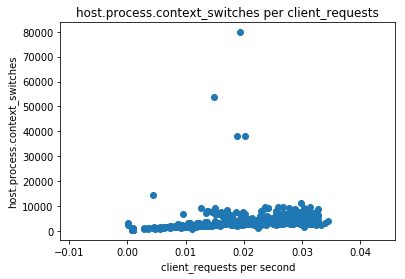

host.process.context_switches
host.process.cpu.io_wait


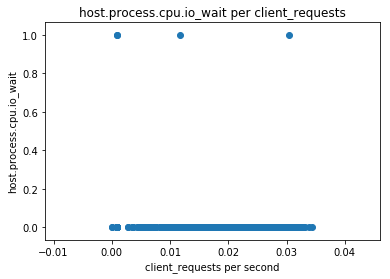

host.process.cpu.io_wait
host.process.cpu.system


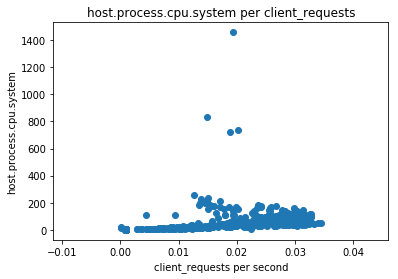

host.process.cpu.system
host.process.cpu.idle


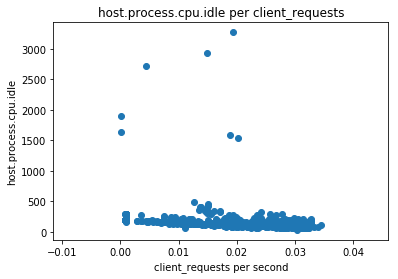

host.process.cpu.idle
host.process.cpu.user


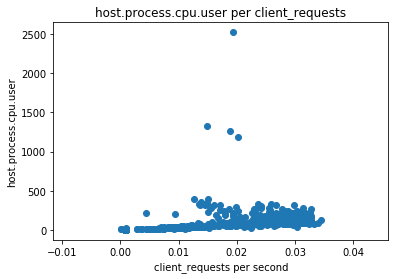

host.process.cpu.user
host.process.cpu.total


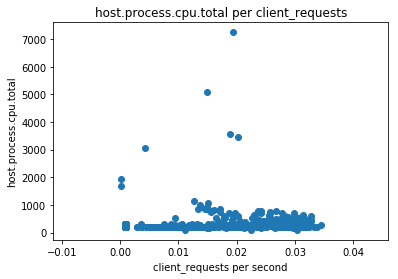

host.process.cpu.total
host.process.hard_interrupts


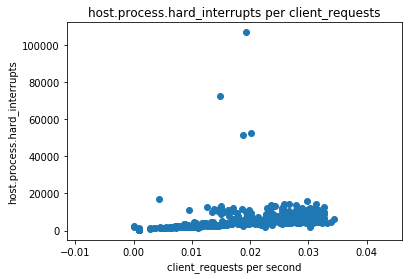

host.process.hard_interrupts
host.network.lo.RX-OK


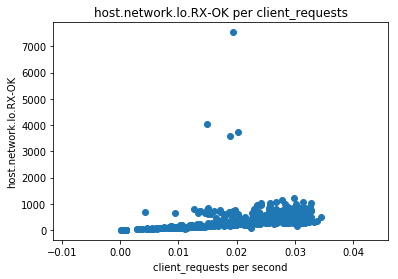

host.network.lo.RX-OK
host.network.lo.TX-OK


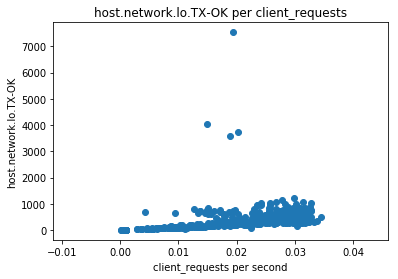

host.network.lo.TX-OK
host.network.enp0s3.RX-OK


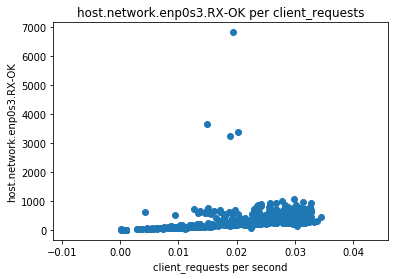

host.network.enp0s3.RX-OK
host.network.enp0s3.TX-OK


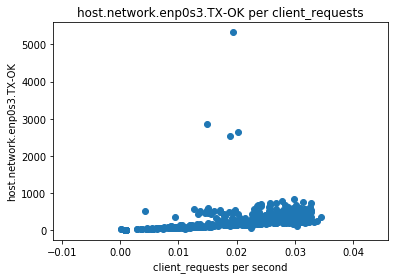

host.network.enp0s3.TX-OK
host.network.enp0s8.RX-OK


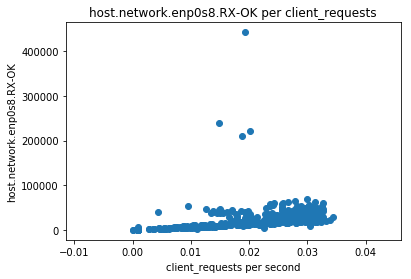

host.network.enp0s8.RX-OK
host.network.enp0s8.TX-OK


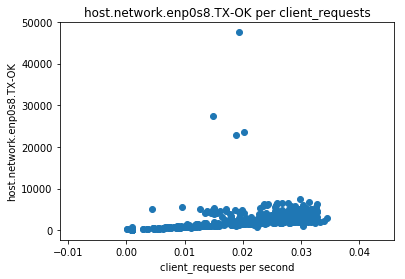

host.network.enp0s8.TX-OK
host.memory.Inactive:.value


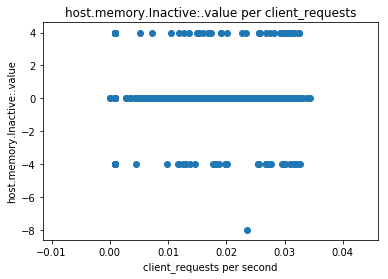

host.memory.Inactive:.value
host.memory.Active:.value


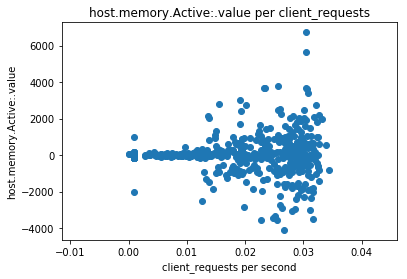

host.memory.Active:.value
host.memory.Cached:.value


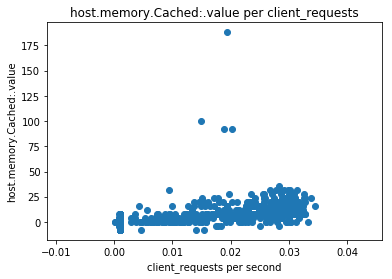

host.memory.Cached:.value
host.memory.Mapped:.value


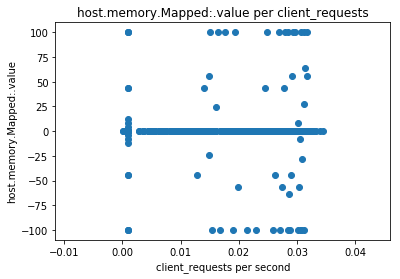

host.memory.Mapped:.value
host.memory.SReclaimable:.value


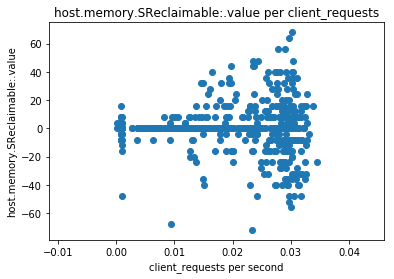

host.memory.SReclaimable:.value
host.memory.Buffers:.value


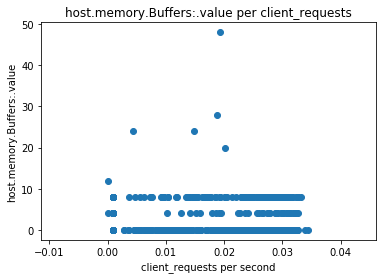

host.memory.Buffers:.value
host.memory.MemAvailable:.value


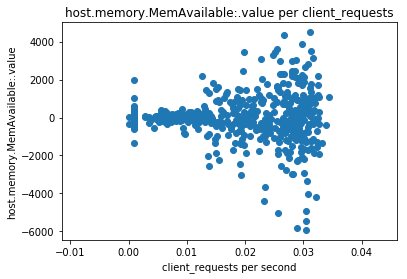

host.memory.MemAvailable:.value
host.memory.SUnreclaim:.value


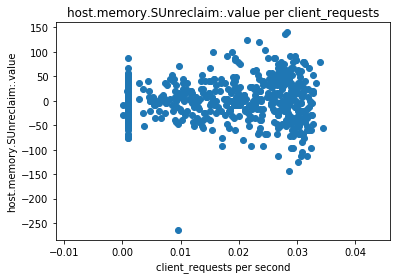

host.memory.SUnreclaim:.value
host.memory.Inactive(file):.value


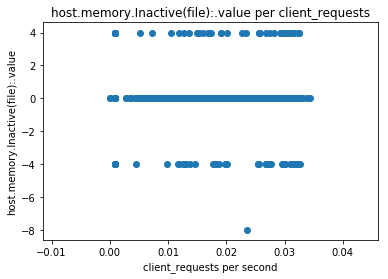

host.memory.Inactive(file):.value
host.memory.Committed_AS:.value


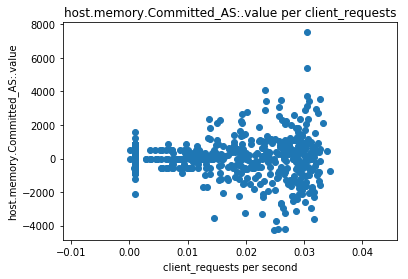

host.memory.Committed_AS:.value
host.memory.PageTables:.value


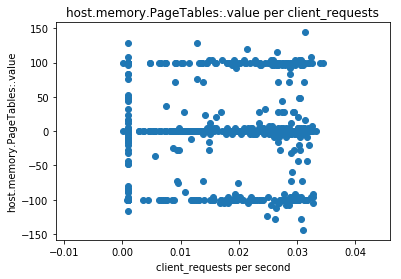

host.memory.PageTables:.value
host.memory.Dirty:.value


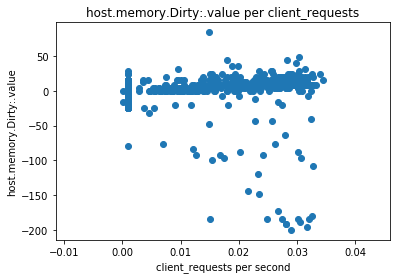

host.memory.Dirty:.value
host.memory.MemFree:.value


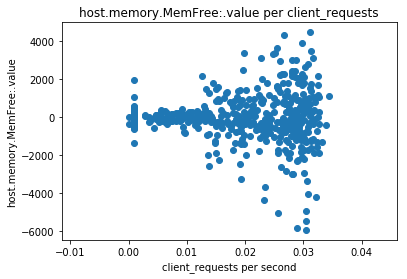

host.memory.MemFree:.value
host.memory.Slab:.value


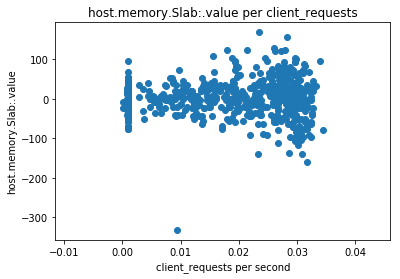

host.memory.Slab:.value
host.memory.AnonPages:.value


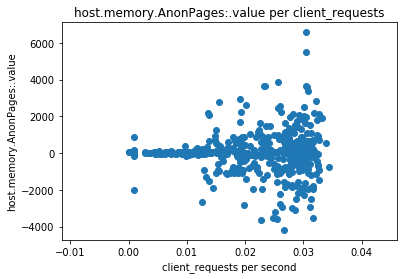

host.memory.AnonPages:.value
host.memory.Active(file):.value


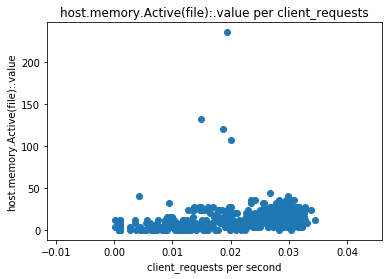

host.memory.Active(file):.value
host.memory.Active(anon):.value


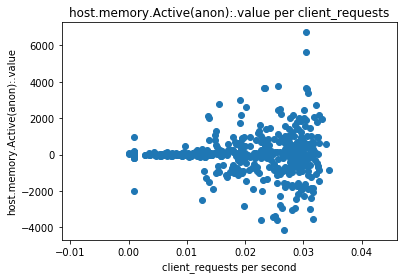

host.memory.Active(anon):.value
host.memory.KernelStack:.value


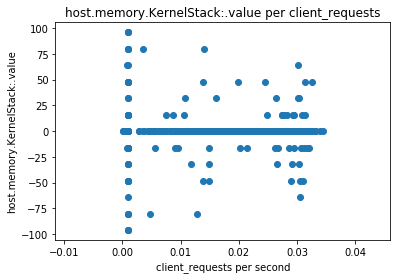

host.memory.KernelStack:.value
t_ms


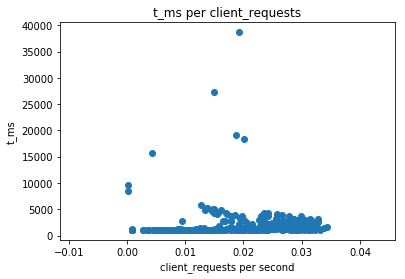

t_ms
client_requests.successful


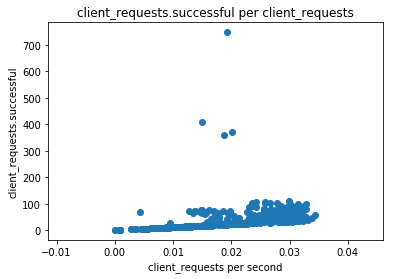

client_requests.successful
client_requests.sent


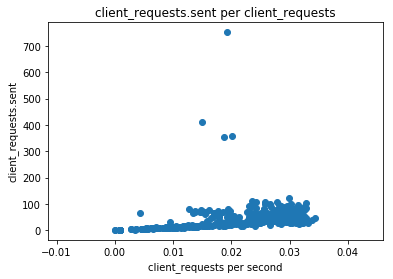

client_requests.sent


In [27]:
%matplotlib inline
import os.path
import json
import operator
import collections
import numpy
import pickle


import matplotlib.pyplot as plt


def get_or_cache(name, object_to_cache):
    filename = name + '.pickle'
    if os.path.exists(filename):
        with open(filename, 'rb') as fp:
            cached_value = pickle.loads(fp.read().encode('utf-8'))
            return cached_value
    else:
        with open(filename, 'w+') as fp:
            fp.write(pickle.dumps(object_to_cache))
    

cpu_stats = get_or_cache('cpu_stats', cpu_stats)


def derivative(stats, i, value_accessor, delta_accessor=None):            
    nxt_val = float(accessor(stats[i+1]))
    cur_val = float(accessor(stats[i]))
    
    delta = 1.
    if delta_accessor:
        nxt_del = float(delta_accessor(stats[i+1]))
        cur_del = float(delta_accessor(stats[i]))
        delta = (nxt_del - cur_del)
    
    return (nxt_val - cur_val) / delta


def accessor_lists(template):
    for k, v in template.items():
        if not isinstance(v, dict):
            yield [k], [operator.itemgetter(k)]
        else:
            for keys, accessor_list in accessor_lists(template[k]):
                yield [k] + keys, [operator.itemgetter(k)] + accessor_list


def access(stat, accessor_list):
    v = stat
    for acc in accessor_list:
        v = acc(v)
    return v


def plot_points(title, x_label, y_label, points):
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    X, Y = points
    plt.scatter(X, Y)
    plt.show()


def uninteresting(stats):
    mean, stddev = stats
    if stddev == 0.:
        return True
    return False


def remove_outliers(X, Y, distribution_statistics, stddevs=3):
    assert len(X) == len(Y)
    mean, stddev = distribution_statistics
    cleaned_X, cleaned_Y = [], []
    for x, y in zip(X, Y):
        if numpy.abs(y) > (numpy.abs(mean) + (stddevs*stddev)):
            continue
        cleaned_X.append(x)
        cleaned_Y.append(y)
    return cleaned_X, cleaned_Y


def plot_stats(stats, derivative=False):
    template = stats[0]
    for labels, accessor_list in accessor_lists(template):
        X, Y, points = [], [], []
        for i, stat in enumerate(stats):
            if i == len(stats) - 1:
                break
            if not derivative:
                x = stat.get('t_ms')
                y = access(stat, accessor_list)
            else:
                # Client requests over duration
                nxt_x = stats[i+1].get('client_requests', {}).get('successful', 0)
                cur_x = stats[i].get('client_requests', {}).get('successful', 0)
                
                # Length of duration
                end_ms = stats[i+1].get('t_ms')
                start_ms = stats[i].get('t_ms')
                
                # Client rps
                client_requests_per_second = (nxt_x - cur_x) / (end_ms - start_ms)
                
                nxt_y = access(stats[i+1], accessor_list)
                cur_y = access(stats[i], accessor_list)
                
                x = client_requests_per_second # Average client RPS over duration
                y = (nxt_y - cur_y)
            X.append(x)
            Y.append(y)
        title = ".".join(labels) + " vs t_ms"
        if derivative:
            title = ".".join(labels) + " per client_requests"
        
        distribution_statistics = get_distribution_statistics(X, Y)
        if uninteresting(distribution_statistics):
            continue
        #X, Y = remove_outliers(X, Y, distribution_statistics, stddevs=3)

        print(".".join(labels))
        plot_points(title, "client_requests per second", ".".join(labels), (X, Y))
        yield ".".join(labels), X, Y


def cast_ts_to_bin(ts, bin_size):
    return int(ts / bin_size) * bin_size
        
        
def bin_stats(stats, ms_bin=100):
    binned = collections.defaultdict(dict)
    for stat in stats:
        bin = cast_ts_to_bin(stat.get('t_ms'), ms_bin)
        binned[bin] = add_stats(stat, binned[bin])
        binned[bin]['t_ms'] = bin
    return sorted([b for b in binned.values()], key=lambda o: o.get('t_ms'))


def get_distribution_statistics(X, Y):
    stddev = numpy.std(Y)
    mean = numpy.mean(Y)
    three_sigma = 2 * stddev
    return mean, stddev
        
        
def add_stats(a, b):
    c = {}
    for k, v in a.items():
        if isinstance(v, dict):
            c[k] = add_stats(a.get(k, {}), b.get(k, {}))
        elif isinstance(v, (int, float)):
            c[k] = a.get(k, 0.) + b.get(k, 0.)
    return c


binned = bin_stats(cpu_stats[1:], ms_bin=1.)
for label, X, Y in plot_stats(binned[1:], derivative=True):
    pass

In [28]:
len(cpu_stats)


1167